In [1]:
!pip install -r requirements.txt

In [2]:
import kagglehub
# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
path = kagglehub.dataset_download("jangedoo/utkface-new")

/home/e20210007813/Bureau/ProjImage/face_filters/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import cv2
import os

In [4]:
# Load face detection classifier
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [5]:
# # This takes like 8 minutes

latent_dim = 128
image_size = 64
images = []

i = 0
# Preprocess images
for root, dirs, files in os.walk(path):
    for file in files:
        if i >= 13000:
            break
        
        if file.endswith(".jpg"):
            i+=1
            img_path = os.path.join(root, file)
            img = cv2.imread(img_path)

            # Handle case where image could not be loaded
            if img is None:
                print(f"Warning: Could not load image {img_path}. Skipping.")
                continue

            # Convert to grey for face detection
            grey_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Call classifier on image to detect faces of any size
            face = face_classifier.detectMultiScale(
                grey_img, scaleFactor=1.1 , minNeighbors=5 , minSize=(40,40)
            )

            # Process and append images only if faces are detected
            if len(face) > 0:
                # Iterate through all detected faces (or pick the first one)
                for (x, y, w, h) in face:
                    x_max = x+w
                    y_max = y+h
                    # Ensure crop coordinates are within image bounds
                    x = max(0, x)
                    y = max(0, y)
                    x_max = min(img.shape[1], x_max)
                    y_max = min(img.shape[0], y_max)

                    if w > 0 and h > 0: # Ensure valid crop dimensions
                        im_cropped = img[y:y_max , x:x_max]

                        # Ensure im_cropped is not empty after cropping
                        if im_cropped.size == 0:
                            print(f"Warning: Empty crop for {img_path}. Skipping.")
                            continue

                        im_cropped = cv2.cvtColor(im_cropped, cv2.COLOR_BGR2RGB)
                        im_cropped = cv2.resize(im_cropped, (image_size, image_size))
                        im_cropped = im_cropped.astype("float32") / 255.0
                        images.append(im_cropped)

In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

images = np.array(images)
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

print("Training shape:", x_train.shape)
print("Test shape:", x_test.shape)

Training shape: (6100, 64, 64, 3)
Test shape: (1525, 64, 64, 3)


In [7]:
import tensorflow as tf
from tensorflow import keras

# Create encoder
encoder = keras.models.Sequential([
    keras.layers.Input((64, 64, 3)),
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'), # I think that if we change the image size we have to change this value
    keras.layers.Dense(latent_dim * 2)
], name="encoder")
encoder.summary()

# Create decoder
decoder = keras.models.Sequential([
    keras.layers.Input((latent_dim,)),
    keras.layers.Dense(8 * 8 * 128, activation='relu'),
    keras.layers.Reshape((8, 8, 128)),
    keras.layers.Conv2DTranspose(128, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2),
    keras.layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')
], name="decoder")
decoder.summary()  


# VAE creation
def sample_latent(z):
    z_mean, z_log_var = tf.split(z, num_or_size_splits=2, axis=1)
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
    return z, z_mean, z_log_var

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Forward pass para predicción / validation
        z_all = self.encoder(inputs)
        z, _, _ = sample_latent(z_all)
        reconstruction = self.decoder(z)
        return reconstruction


# UNUSED !!!!! :(
# Kept for evil spirits
def vae_loss(y_true, y_pred):
    # Reconstrucción 👷
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))

    # KL divergence
    z_all = vae.encoder(y_true)
    z_mean, z_log_var = tf.split(z_all, num_or_size_splits=2, axis=1)
    kl_loss = -0.5 * tf.reduce_mean(
        tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
    )

    return reconstruction_loss + kl_loss

# Damned souls (red)
# CLOSER THAN THE OTHER ONE 
# https://www.tensorflow.org/tutorials/generative/cvae
def elbo_loss(y_true, y_pred):
    z_all = vae.encoder(y_true)
    z,z_mean,z_log_var = sample_latent(z_all)
    # z_mean, z_log_var = tf.split(z, num_or_size_splits=2, axis=1)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred, labels=y_true)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, z_mean, z_log_var)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

#wassertien 
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss=elbo_loss)

2025-11-19 11:19:29.810156: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 11:19:29.846954: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 11:19:40.354762: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 11:19:45.481763: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,256,448 (8.61 MB)

 Trainable params: 2,256,448 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 8192)           │     1,056,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,297,475 (4.95 MB)

 Trainable params: 1,297,475 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the vae
epochs = 1000
batch_size = 128
vae.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, x_test)
)

Epoch 1/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 8485.5498 - val_loss: 8375.9990
Epoch 2/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 8331.4463 - val_loss: 8271.9648
Epoch 3/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 8232.9795 - val_loss: 8192.6514
Epoch 4/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 8185.0288 - val_loss: 8173.9038
Epoch 5/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 8172.1602 - val_loss: 8162.9854
Epoch 6/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 8162.4653 - val_loss: 8151.6064
Epoch 7/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 8154.0713 - val_loss: 8147.4966
Epoch 8/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 8151.1753 - val_loss: 8144.7168
Epoch 9/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 8148.4995 - val_loss: 8144.0684
Epoch 10/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 8146.7974 - val_loss: 8142.2749
Epoch 11/1000
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - lo

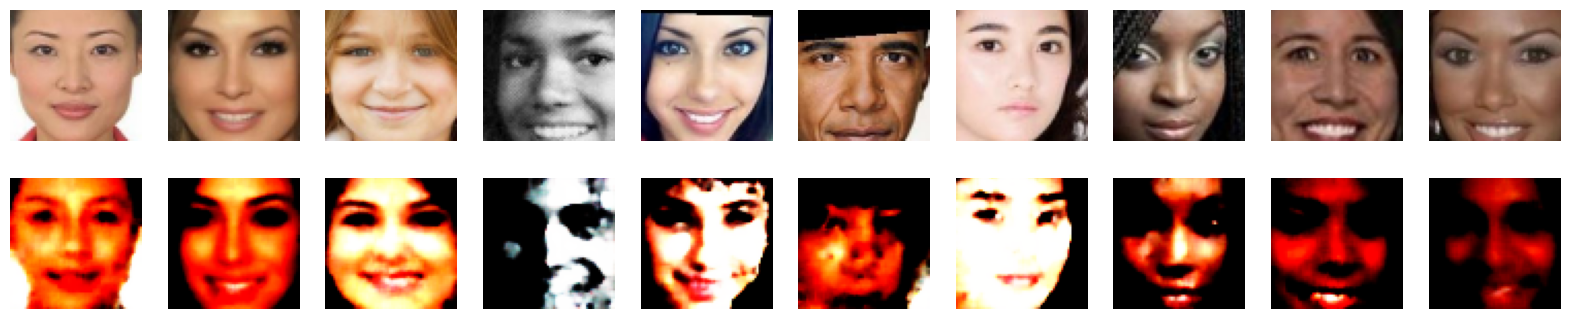

In [9]:
# Compare original and reconstructed images
import matplotlib.pyplot as plt
import numpy as np

n = 10
z_all = vae.encoder(x_test[:n])
z, _, _ = sample_latent(z_all)
decoded_imgs = vae.decoder(z)

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.axis("off")
plt.show()

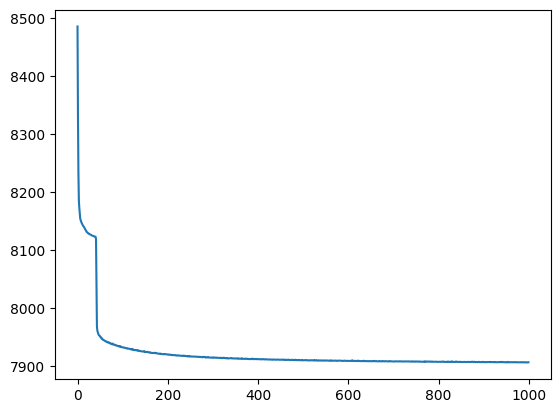

In [11]:
loss = vae.history.history['loss']
epoch_range = range(epochs)

plt.plot(epoch_range, loss, label='Training Loss')

In [27]:
vae.encoder.save('vae_encoder.keras')
vae.decoder.save('vae_decoder.keras')

vae.save_weights('vae_weights.weights.h5')